# Recommendation of tariffs

The mobile operator Megaline found out that many customers use archive tariffs. They want to build a system capable of analyzing customer behavior and offering users a new tariff: "Smart" or "Ultra".

We have data on the behavior of customers who have already switched to these tariffs. You need to build a model for the classification problem that will choose the appropriate tariff. Data preprocessing is not required.

## Importing and analyzing data

In [1]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import accuracy_score
import seaborn as sns
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
import warnings
warnings.filterwarnings("ignore")

In [2]:
# fix the random_state
random_state = 12345

In [3]:
df = pd.read_csv('datasets/users_behavior.csv')
df

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0
...,...,...,...,...,...
3209,122.0,910.98,20.0,35124.90,1
3210,25.0,190.36,0.0,3275.61,0
3211,97.0,634.44,70.0,13974.06,0
3212,64.0,462.32,90.0,31239.78,0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   calls     3214 non-null   float64
 1   minutes   3214 non-null   float64
 2   messages  3214 non-null   float64
 3   mb_used   3214 non-null   float64
 4   is_ultra  3214 non-null   int64  
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


Each object in the dataset is information about the behavior of one user per month.

- calls — number of calls,
- minutes — total duration of calls in minutes,
- messages — number of sms messages,
- mb_used — consumed internet traffic in MB,
- is_ultra — what tariff was used during the month ("Ultra" — 1, "Smart" — 0).

The data has already been processed and is ready for analysis.

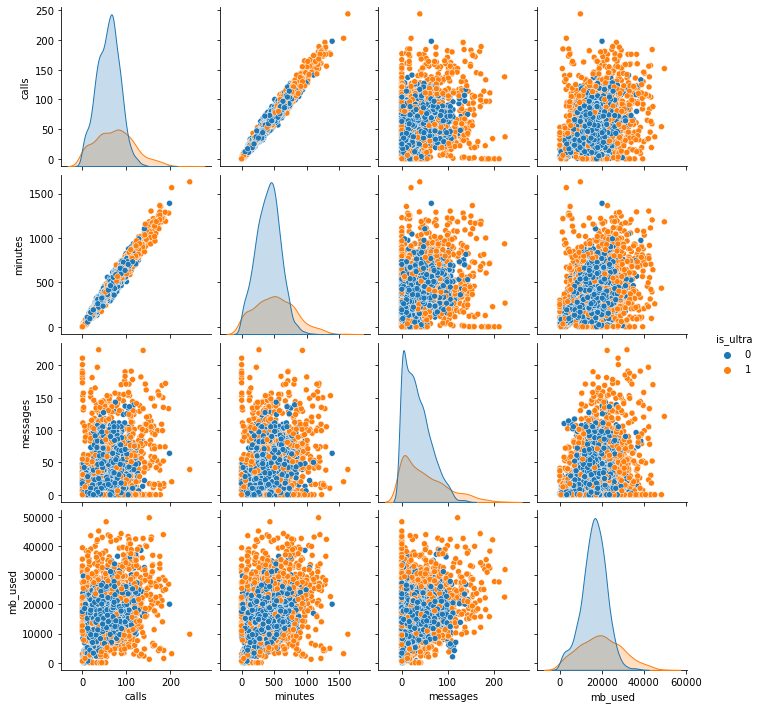

In [5]:
sns.pairplot(df,hue = 'is_ultra');

## Splitting data into samples

In [6]:
features = df.drop(columns='is_ultra')
target = df['is_ultra']

In [7]:
df_train, df_valid = train_test_split(df, test_size=0.4, random_state=random_state)
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=random_state)

In [8]:
len(df_train)

1928

In [9]:
len(df_valid)

643

In [10]:
len(df_test)

643

We have divided the data as follows:
- Training sample (60%)
- Validation sample (20%)
- Test sample (20%)

## Model research

We will build models based on:
- Decision tree
- Random forest
- Linear regression

### First, we will divide the samples into features and target

In [11]:
features_train = df_train.drop(columns='is_ultra')
target_train = df_train['is_ultra']

features_valid = df_valid.drop(columns='is_ultra')
target_valid = df_valid['is_ultra']

features_test = df_test.drop(columns='is_ultra')
target_test = df_test['is_ultra']

### Decision tree

In [12]:
params = {
    'max_depth': range(2, 10, 1),
    'min_samples_leaf':range(1,4,1)
}
model = DecisionTreeClassifier(random_state=random_state)

dt = GridSearchCV(
        model,
        params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1)

dt.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(random_state=12345),
             n_jobs=-1,
             param_grid={'max_depth': range(2, 10),
                         'min_samples_leaf': range(1, 4)},
             scoring='accuracy')

In [13]:
print(f'Best accuracy score = {round(dt.best_score_,3)}, with parameters {dt.best_params_}')

Best accuracy score = 0.802, with parameters {'max_depth': 3, 'min_samples_leaf': 1}


### Random Forest

In [14]:
params = {
    'max_depth': range(2, 10, 1),
    'min_samples_leaf':range(1,4,1),
    'n_estimators':range(100,400,50)
}
model = RandomForestClassifier(random_state=random_state)

rf = RandomizedSearchCV(
        model,
        params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1, n_iter=50)

rf.fit(features_train, target_train)

RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(random_state=12345),
                   n_iter=50, n_jobs=-1,
                   param_distributions={'max_depth': range(2, 10),
                                        'min_samples_leaf': range(1, 4),
                                        'n_estimators': range(100, 400, 50)},
                   scoring='accuracy')

In [15]:
print(f'Best accuracy score = {round(rf.best_score_,3)}, with parameters {rf.best_params_}')

Best accuracy score = 0.821, with parameters {'n_estimators': 350, 'min_samples_leaf': 2, 'max_depth': 9}


We got a better result than with a simple Decision Tree

### Logistic Regression

In [16]:
params = {
    'penalty': ['none','l2','l1','elasticnet'],
    'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000]
}
model = LogisticRegression()

lr = GridSearchCV(
        model,
        params,
        scoring='accuracy',
        cv=5,
        n_jobs=-1)

lr.fit(features_train, target_train)

GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['none', 'l2', 'l1', 'elasticnet']},
             scoring='accuracy')

In [17]:
print(f'Best accuracy score = {round(lr.best_score_,3)}, with parameters {lr.best_params_}')

Best accuracy score = 0.749, with parameters {'C': 0.001, 'penalty': 'l2'}


Logistic regression showed the worst accuracy score in this sample

### Conclusion

Random Forest is the best model with following parameters:
- accuracy 0.821
- n_estimators 300
- max_depth 9
- min_samples_leaf 2

## Checking the models on a test sample

### Decision Tree

In [18]:
model = DecisionTreeClassifier(random_state=random_state, max_depth = dt.best_params_['max_depth'],
                              min_samples_leaf = dt.best_params_['min_samples_leaf'])
model.fit(features_train,target_train)
predictions = model.predict(features_test)
best_model = accuracy_score(predictions, target_test)
print(f'Accuracy score = {round(best_model,3)}')

Accuracy score = 0.779


### Random Forest

In [19]:
model = RandomForestClassifier(random_state=random_state, max_depth = rf.best_params_['max_depth'],
                              min_samples_leaf = rf.best_params_['min_samples_leaf'], 
                               n_estimators = rf.best_params_['n_estimators'])
model.fit(features_train,target_train)
predictions = model.predict(features_test)
best_model = accuracy_score(predictions, target_test)
print(f'Accuracy score = {round(best_model,3)}')

Accuracy score = 0.809


### Logistic Regression

In [20]:
model = LogisticRegression(penalty=lr.best_params_['penalty'], C=lr.best_params_['C'])
model.fit(features_train,target_train)
predictions = model.predict(features_test)
print(f'Accuracy score = {round(accuracy_score(predictions, target_test),3)}')

Accuracy score = 0.687


### Conclusion

The **Random Forest** model also showed best results on the test data

### Model training on a sample training+validation

In [21]:
features_train_valid = features_train.append(features_valid, ignore_index=True)
target_train_valid = target_train.append(target_valid, ignore_index=True)

In [22]:
model = RandomForestClassifier(random_state=random_state, max_depth = rf.best_params_['max_depth'],
                              min_samples_leaf = rf.best_params_['min_samples_leaf'], 
                               n_estimators = rf.best_params_['n_estimators'])
model.fit(features_train_valid,target_train_valid)
predictions = model.predict(features_test)
best_model = accuracy_score(predictions, target_test)
print(f'Accuracy score = {round(best_model,3)}')

Accuracy score = 0.806


When combining the two samples, the result **improved** slightly

### Bonus. Checking the Random Forest model for adequacy on constant model

In [23]:
constant_model = target_test*0+1

In [24]:
model = RandomForestClassifier(random_state=random_state, max_depth = rf.best_params_['max_depth'],
                              min_samples_leaf = rf.best_params_['min_samples_leaf'], 
                               n_estimators = rf.best_params_['n_estimators'])
model.fit(features_train_valid,target_train_valid)
predictions = model.predict(features_test)
best_model = accuracy_score(predictions, constant_model)
print(f'Accuracy score on the constant model = {round(best_model,3)}')

Accuracy score on the constant model = 0.224


Accuracy score on the constant model is much worse, which indicates the **adequacy of our model**.